<h1 align='center'>INET4061 Final- Audio Sentiment Analysis</h1>
<h2 align='center'>Michael Greene 4766783 gree1886</h2>

This project aims to propose the next step for virtual assistants like Siri and Alexa. These complicated AI are good at what theye do, but they would be better if they could be a little empathetic. To achieve empathy in these AI, it is necessary for the input audio to be analyzed for sentiment. This project proposes a way to do exactly this- sentiment analysis for audio signals.

In [1]:
# AROUSAL -> ENERGY, VALENCE -> SUBJECTIVE LABEL
# in context, high arousal and valence -> excitement
# low arousal, high valence -> happy
# low arousal, low valence -> sad ()
# high arousal, low valence -> anger (ex 00.wav)
import warnings
warnings.filterwarnings('ignore')
import librosa as lr
print(lr.__version__)

0.6.2


<h3>Data</h3><br><br>
Data source found here- https://github.com/tyiannak/pyAudioAnalysis/tree/master/pyAudioAnalysis/data<br><br>
PyAudioAnalysis has numerous great tools which were used in a previous study of the same topic- unfortunately the feature extraction and visualization features are not as clear or helpful as those in LibROSA

In [2]:
# SAMPLES FOR EXPLORATORY DA
datapath = "data/speechEmotion/"
data1, smplRt1 = lr.load(datapath + "00.wav")
data2, smplRt2 = lr.load(datapath + "22.wav")
print(lr.samples_to_time(len(data1), smplRt1))  # time duration of sample

2.0875736961451246


In [3]:
# ALL DATA AND TARGETS FOR TRAIN/TEST
import glob, os
import pandas as pd
from sklearn.model_selection import train_test_split
data = []
for file in sorted(glob.glob(datapath + "*.wav")):
    data.append(lr.load(file))
arousalTargets = pd.read_csv(datapath + "arousal.csv", header = None)
valenceTargets = pd.read_csv(datapath + "valence.csv", header = None)
# WARNING: ORDERING DEPENDENCE
targets = (arousalTargets.join(valenceTargets, 
                              lsuffix = "arousal", 
                              rsuffix = "valence")
           .drop(['0valence'], axis = 1)
           .rename({"0arousal": "file",
                    "1arousal": "arousal",
                    "1valence": "valence"},
                   axis = 1))

<h3>Exploratory Data Analysis</h3>

Tools for extracting audio features and visualizing them found here- https://librosa.github.io/librosa/

<h4>Wave envelope plots</h4>

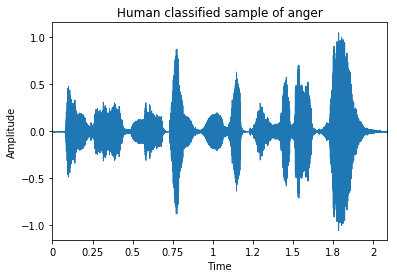

In [24]:
import matplotlib.pyplot as plt
import librosa.display
lr.display.waveplot(data1, smplRt1)
plt.title("Human classified sample of anger")
plt.ylabel("Amplitude")
plt.show()

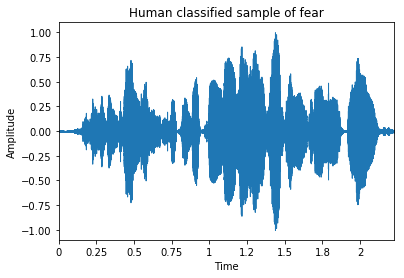

In [5]:
lr.display.waveplot(data2, smplRt2)
plt.title("Human classified sample of fear")
plt.ylabel("Amplitude")
plt.show()

<h4>Audio Spectrograms</h4>

Following graphs are interpreted as relating the energy by the color dimension. Frequency and energy are related, so a brighter color means the wave amplitude is actually greater for the given frequecy.<br>
The scale for the Y-axis is known as the Mel-scale. It segments the frequency range into bands in a way that mimicks how humans segment frequencies when discerning pitch.

<b>Each datum represents the area under the amplitude vs time curve (shown above) for the short-time window centered on the datum</b>

Area under the amplitude vs time curve explains why higher pitches are experienced as more intense for frequencies within the range of human perception

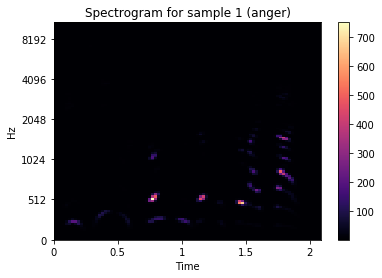

In [6]:
melspec1 = lr.feature.melspectrogram(data1, smplRt1)
lr.display.specshow(melspec1, y_axis = "mel", x_axis = "time")
plt.title("Spectrogram for sample 1 (anger)")
plt.colorbar()
plt.show()

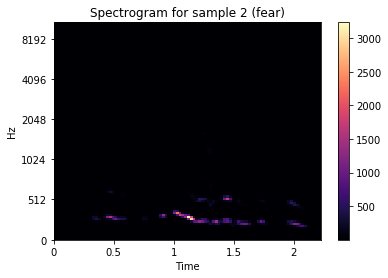

In [7]:
melspec2 = lr.feature.melspectrogram(data2, smplRt2)
lr.display.specshow(melspec2, y_axis = "mel", x_axis = "time")
plt.title("Spectrogram for sample 2 (fear)")
plt.colorbar()
plt.show()

<h4>Audio Chromagrams</h4>

This graph is similar to a spectrogram, but intensity values for octaves are combined into a single Pitch class (or a note in a musical scale). Some interesting graphs will also combine the 3rd and 5th note of a scale with the ocatves, creating a plot with less obvious discrete "blocks".

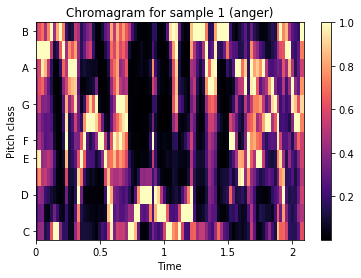

In [8]:
chroma1 = lr.feature.chroma_stft(data1, smplRt1)
lr.display.specshow(chroma1, y_axis="chroma", x_axis="time")
plt.title("Chromagram for sample 1 (anger)")
plt.colorbar()
plt.show()

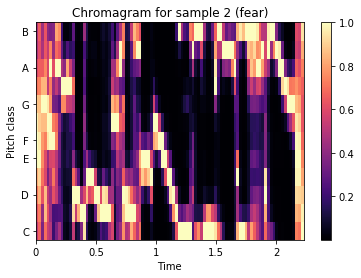

In [9]:
chroma2 = lr.feature.chroma_stft(data2, smplRt2)
lr.display.specshow(chroma2, y_axis="chroma", x_axis="time")
plt.title("Chromagram for sample 2 (fear)")
plt.colorbar()
plt.show()

<i>At this point it seems like the chromagram contains the most information about the sample, so this will be used as input to the classification model. Another benefit of the chromagram is fewer features- this is not intuitive but observe that most pixels in the spectrogram are black and contain no useful information</i>

The first challenge- audio samples of differing time length must be resized to conform to the same shape. This is done by adjusting the "pixel density" of the image.

In [10]:
from skimage.transform import resize
print("spectrogram1 shape: ", melspec1.shape, "\n")
print("chroma1 shape: ", chroma1.shape)
print("chroma2 shape", chroma2.shape, "\n")
resizedata1 = resize(chroma1, (12, 100))  # interpolation to down-size
resizedata2 = resize(chroma2, (12, 100))
print("new chroma1 shape: ", resizedata1.shape)
print("new chroma2 shape: ", resizedata2.shape)

spectrogram1 shape:  (128, 90) 

chroma1 shape:  (12, 90)
chroma2 shape (12, 96) 

new chroma1 shape:  (12, 100)
new chroma2 shape:  (12, 100)


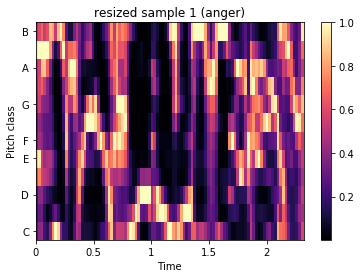

In [11]:
lr.display.specshow(resizedata1, y_axis="chroma", x_axis="time")
plt.title("resized sample 1 (anger)")
plt.colorbar()
plt.show()

This image is essentially the same as the 1st samples chromagram but dilated along the time axis. The "new" data is created by interpolating points in a short-time window. This assures no loss of information

<h4>Data pre-processing</h4>
First the audio samples are converted to a chromagram and resized to ensure uniformity. Then data is partitioned into training and testing sets for input into the model.

In [12]:
from sklearn.model_selection import train_test_split
import numpy as np
cgrams = []
for i in range(len(data)):
    # convert to chromagram
    cgram = lr.feature.chroma_stft(data[i][0], data[i][1])
    # resize and add to array
    cgrams.append(resize(cgram, (12, 100, 1)))

# partition the data into train/test sets
xtrain, xtest, ytrain, ytest = train_test_split(cgrams,
                                                targets,
                                                test_size = .2)

xtrain = np.array(xtrain)
xtest = np.array(xtest)

<h3>Models</h3>
There will be two models tested, each with different architectures.

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
import numpy as np

Using TensorFlow backend.


In [14]:
model = Sequential()
model.add(Conv2D(100, kernel_size=3, 
                 activation='tanh',
                input_shape=(12, 100, 1)))
model.add(Conv2D(50, kernel_size=3, activation='tanh'))
model.add(Conv2D(25, kernel_size=3, activation='tanh'))
model.add(Conv2D(10, kernel_size=3, activation='tanh'))
model.add(Flatten())
model.add(Dense(1, activation='tanh'))
model.compile(optimizer='sgd', loss='mean_squared_error')

In [15]:
model.fit(xtrain, ytrain['arousal'], 
                         validation_data=(xtest, ytest['arousal']),
         epochs=3)

Train on 37 samples, validate on 10 samples
Epoch 1/3
37/37 [==============================] - 0s 12ms/step - loss: 0.3008 - val_loss: 0.4146
Epoch 2/3
37/37 [==============================] - 0s 6ms/step - loss: 0.2745 - val_loss: 0.5635
Epoch 3/3
37/37 [==============================] - 0s 6ms/step - loss: 0.3060 - val_loss: 0.3972


In [16]:
pred = model.predict(xtest[:5])
pred

array([[ 0.03395084],
       [-0.28097948],
       [-0.03630862],
       [-0.07700291],
       [ 0.09536181]], dtype=float32)

In [17]:
ytest[:5]

,file,arousal,valence
3,03.wav,0.90,-0.70
18,18.wav,0.80,0.90
31,31.wav,-0.25,-0.20
39,39.wav,0.00,-0.12
4,04.wav,0.90,-0.90


<b>The model is essentially assigning values randomly. This is probably due to lack of training data. A new model will be created with a different strategy- using a large dataset with subjective labels rather than (arousal, valence)</b><br><br>
new data https://zenodo.org/record/1188976#.XA1OactKj0o

In [18]:
from keras.utils import np_utils
targets = []
cgrams = []
for folder in glob.glob("Actor_*"):
    for file in glob.glob(folder + "/*.wav"):
        data, sr = lr.load(file)
        chroma = lr.feature.chroma_stft(data, sr)
        cgrams.append(resize(chroma, (12, 120, 1)))
        strv = file.split('-')
        targets.append(int(strv[2]))  # labels included in file names

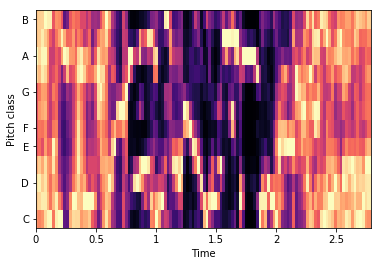

In [19]:
cgrams = np.array(cgrams)
#targets = np_utils.to_categorical(targets)
xtrain, xtest, ytrain, ytest = train_test_split(cgrams, targets, test_size=.3)
lr.display.specshow(cgrams[0].reshape((12, 120)), y_axis="chroma", x_axis="time")

In [20]:
model = Sequential()
model.add(Conv2D(50, kernel_size=3, 
                 activation='relu',
                input_shape=(12, 120, 1)))
model.add(Conv2D(50, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.25))
model.add(Conv2D(50, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(9, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [21]:
ytrain = np.array(ytrain)
ytest = np.array(ytest)
ytrain.shape
history = model.fit(xtrain, ytrain,
          validation_data=(xtest, ytest),
          epochs=12)

Train on 1008 samples, validate on 432 samples
Epoch 1/12
1008/1008 [==============================] - 4s 4ms/step - loss: 2.1076 - val_loss: 2.0867
Epoch 2/12
1008/1008 [==============================] - 4s 3ms/step - loss: 2.0542 - val_loss: 2.0563
Epoch 3/12
1008/1008 [==============================] - 4s 4ms/step - loss: 1.9659 - val_loss: 1.9154
Epoch 4/12
1008/1008 [==============================] - 4s 4ms/step - loss: 1.7684 - val_loss: 1.8476
Epoch 5/12
1008/1008 [==============================] - 4s 4ms/step - loss: 1.5703 - val_loss: 1.6496
Epoch 6/12
1008/1008 [==============================] - 4s 4ms/step - loss: 1.4473 - val_loss: 1.6165
Epoch 7/12
1008/1008 [==============================] - 4s 4ms/step - loss: 1.3318 - val_loss: 1.5969
Epoch 8/12
1008/1008 [==============================] - 4s 4ms/step - loss: 1.1981 - val_loss: 1.6240
Epoch 9/12
1008/1008 [==============================] - 4s 4ms/step - loss: 1.1065 - val_loss: 1.5602
Epoch 10/12
1008/1008 [============

<h3>Model Evaluation</h3>

Using a confusion matrix to evaluate the model

In [22]:
from sklearn.metrics import confusion_matrix
testlabels = model.predict(xtest)
labels = []
for label in testlabels:
    labels.append(np.argmax(label))
    
emotions = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
cmat = pd.DataFrame(confusion_matrix(ytest, labels))
cmat.columns = emotions
cmat.rows = emotions
cmat

,neutral,calm,happy,sad,angry,fearful,disgust,surprised
0,15,9,2,3,2,3,0,5
1,3,35,1,4,2,2,2,1
2,3,5,15,9,5,7,1,11
3,5,14,6,16,3,8,1,4
4,2,2,7,2,27,5,4,8
5,2,7,6,9,2,30,3,3
6,2,5,1,1,15,2,26,4
7,1,3,2,0,4,5,5,35


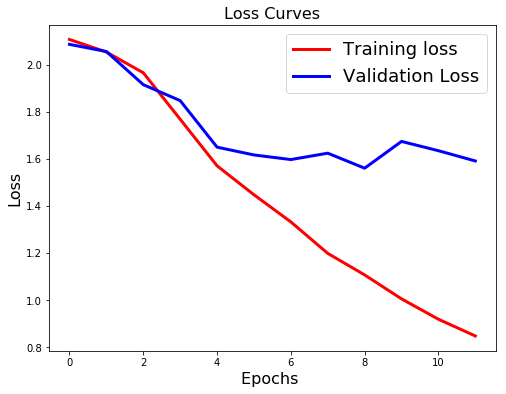

In [23]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

<h3>Conclusions</h3>
The model frequently mistook happiness for fear and surprise- this seems natural because the frequency range for each is expected to be similar. The energy behind a happy expression can cause some of these false positives as well. High energy happiness could be mistaken for surprise, while low energy happiness could be misclassified as calm. In fact, any low energy signal could be misclassified as calm. This leads to a shortcoming of this model.

The tendency to "overweight" the energy feature is caused by the actual representation of the input signal. A fast fourier transform is performed and from this information the frequency, wave amplitude and time dimensions are captured. This information is sufficient to perform extensive analysis on the energy of the signal, but is not sufficient to perform sentiment analysis which would differentiate between emotions in low-energy samples.

Audio features which would afford insightful sentiment analysis include MFCC's and spectral flux.

<h3>Sources</h3>
1] Lie Lu, Hong-Jiang Zhang, Hao Jiang. October 2002. Content Analysis for
Audio Classification and Segmentation. IEEE TRANSACTIONS ON SPEECH
AND AUDIO PROCESSING, VOL. 10, NO. 7.

[2] Saadia Zahid, Fawad Hussain, Muhammad Rashid, Muhammad Haroon
Yousaf, and Hafiz Adnan Habib, “Optimized Audio Classification and Segmen-
tation Algorithm by Using Ensemble Methods,” Mathematical Problems in En-
gineering, vol. 2015, Article ID 209814, 11 pages, 2015. https://doi.org/10.1155/2015/209814.

[3] Bengolea G., Acevedo D., Rais M., Mejail M. (2014) Feature Analysis for Au-
dio Classification. In: Bayro-Corrochano E., Hancock E. (eds) Progress in Pat-
tern Recognition, Image Analysis, Computer Vision, and Applications. CIARP
2014. Lecture Notes in Computer Science, vol 8827

[4] McLoughlin I, Zhang H, Xie Z, Song Y, Xiao W, Phan H (2017) Continuous
robust sound event classification using time-frequency features and deep learn-
ing. PLoS ONE 12(9): e0182309. https://doi.org/10.1371/journal.pone.0182309

[5] Jonathan Dennis, Huy Dat Tran, Haizhou Li. (2011) Spectrogram Image
Feature for Sound Event Classification in Mismatched Conditions. IEEE Signal
Processing Letters ( Volume: 18, Issue: 2)

[6] S. Hershey et al., ”CNN architectures for large-scale audio classification,”
2017 IEEE International Conference on Acoustics, Speech and Signal Processing
(ICASSP), New Orleans, LA, 2017, pp. 131-135. doi: 10.1109/ICASSP.2017.7952132
keywords: audio signal processing;image classification;neural nets;video signal
processing;vocabulary;70M training video dataset;AlexNet neural networks;CNN;DNN;Inception
neural networks;ResNet neural networks;VGG neural networks;audio classifica-
tion task;convolutional neural networks;deep neural networks;image classifica-
tion;label vocabulary;large-scale audio classification;soundtrack classification;training
set;video-level labels;Computer architecture;Hidden Markov models;Neural net-
works;Servers;Spectrogram;Training;Videos;Acoustic Event Detection;Acoustic
Scene Classification;Convolutional Neural Networks;Deep Neural Networks;Video
Classification, URL: http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=arnumber=7952132isnumber=7951776

[7] Yim J., Ju J., Jung H., Kim J. (2015) Image Classification Using Convo-
lutional Neural Networks With Multi-stage Feature. In: Kim JH., Yang W., Jo
J., Sincak P., Myung H. (eds) Robot Intelligence Technology and Applications
3. Advances in Intelligent Systems and Computing, vol 345. Springer, Cham.

[8] Ian Vince McLoughlin. (2007). A review of line spectral pairs. School
of Computer Engineering, Nanyang Technological University.